In [1]:
stock_symbol = '#TSLA'  # Beispiel: PLTR, kann angepasst werden
#import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Dow Theorie: Trendanalyse
def dow_theory(data):
    # Identifikation von Aufwärtstrends und Abwärtstrends (basiert auf Schlusskursen)
    data['Trend'] = np.where(data['close'] > data['close'].shift(1), '1', '0')
    return data



# Elliott Wellen Theorie: Eine einfache Methode zur Identifikation von Wellen
def elliott_wave(data):
    # Berechnung der Rückgänge und Anstiege (ein rudimentäres Beispiel)
    data['Wave_Up'] = np.where(data['close'] > data['close'].shift(1), 1, 0)
    data['Wave_Down'] = np.where(data['close'] < data['close'].shift(1), 1, 0)
    
    # Identifikation von Wellen (dies ist ein vereinfachtes Beispiel)
    data['Wave_Count'] = data['Wave_Up'].cumsum() - data['Wave_Down'].cumsum()
    return data

# Daten laden
#df = yf.download('TSLA', start='2020-01-01')


folderPath_His = "/Users/Shared/ai_work/Trainingdata/ml_data/yh_his/D1/"


lastBars =20
n_time_steps = 60 # Anzahl der Zeitstufen
n_pred_days = 100 # Anzahl der Vorhersagetage
n_tail= 1000
df = pd.read_csv (folderPath_His + stock_symbol + ".csv")
print (df.head())
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df["date"])
#dt.strftime('%Y-%m-%d')


#df["date"] = df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

df = df.set_index('date')
df = dow_theory(df)

df = elliott_wave(df)
df = df[:len(df) - lastBars]

print (df)
#df['AUDUSD_close'] = df['AUDUSD_close'].shift(1)
"""
df = df[['open', 'high', 'low', 'close','volume','AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume','cot_noncom_long','cot_com_short',
         'cot_noncom_short','cot_openinterest','F_TYield_13W_close','F_US_TBond_close','F_US_TBond_volume','F_VIX_close',
         'F_USDX_close','Trend','Wave_Down','Wave_Up','Wave_Count']]
"""
df1 = df[['open', 'high', 'low', 'close', 'volume']]
df['MA_14'] = df['close'].rolling(window=14).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['MA_200'] = df['close'].rolling(window=200).mean()
df['RSI_14'] = 100 - (100 / (1 + df['close'].pct_change().add(1).rolling(14).apply(lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if abs(x[x < 0].mean()) > 0 else 0)))
df['Sentiment'] = np.random.uniform(-1, 1, size=len(df))  # Dummy

ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Returns'] = round( df['close'].pct_change() , 5 )
df['MA200_diff'] = round( ((df['close'] - df['MA_200'])/df['close'] ), 5 )
df.dropna(inplace=True)
if n_tail > 0: df = df.tail(n_tail)
#'MA_14','MA_50', 'RSI_14'
features = [ 'Returns', 'volume', 'open', 'high','low','Returns','MA_14','RSI_14'
            ]
#features = ['open', 'high', 'low', 'volume', 'MA_14', 'RSI_14', 'F_TNote_10Y_close','F_TYield_13W_close','F_VIX_close','F_USDX_close']
target = 'close'


   Unnamed: 0 symbol        date      open      high       low     close  \
0           0  #TSLA  2010-06-29  1.266667  1.666667  1.169333  1.592667   
1           1  #TSLA  2010-06-30  1.719333  2.028000  1.553333  1.588667   
2           2  #TSLA  2010-07-01  1.666667  1.728000  1.351333  1.464000   
3           3  #TSLA  2010-07-02  1.533333  1.540000  1.247333  1.280000   
4           4  #TSLA  2010-07-06  1.333333  1.333333  1.055333  1.074000   

      volume  adjclose ticker type  id  dividends  splits  
0  281494500  1.592667   TSLA   D1   0        0.0     0.0  
1  257806500  1.588667   TSLA   D1   1        0.0     0.0  
2  123282000  1.464000   TSLA   D1   2        0.0     0.0  
3   77097000  1.280000   TSLA   D1   3        0.0     0.0  
4  103003500  1.074000   TSLA   D1   4        0.0     0.0  
            Unnamed: 0 symbol        open        high         low       close  \
date                                                                            
2010-06-29           

/tmp/ipykernel_67065/3282341810.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df["date"])


In [2]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, time_steps=n_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps].flatten())  # Flatten für sklearn
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)


In [3]:
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_seq, y_seq.ravel())


,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


In [4]:
last_input = X_scaled[-n_time_steps:]  # letzte 30 Tage
predictions = []

for _ in range(n_pred_days):
    X_input = last_input.flatten().reshape(1, -1)
    pred_scaled = model.predict(X_input)[0]
    predictions.append(pred_scaled)

    # Neues Feature-Sample simulieren
    new_row = last_input[-1].copy()
    new_row[-1] = pred_scaled  # close-Simulation als letztes Feature (Sentiment bleibt gleich hier)
    last_input = np.vstack((last_input[1:], new_row))

# Zurückskalieren
predicted_prices = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))


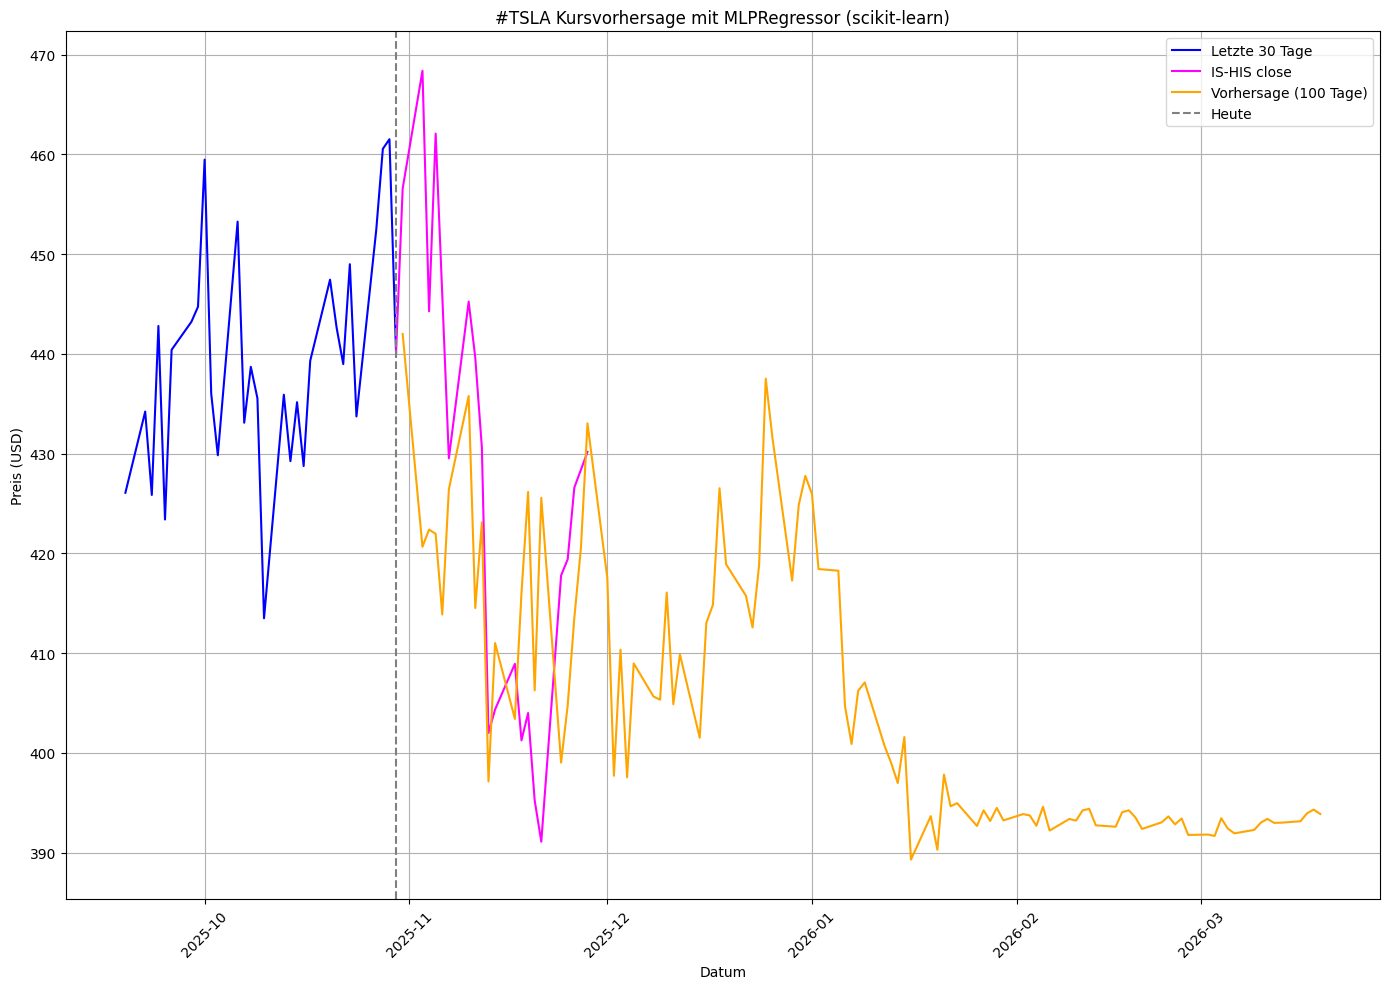

In [5]:
import matplotlib.dates as mdates

df.index = pd.to_datetime(df.index)
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_pred_days, freq='B')
df_fc = ['date','fc']

#plt.figure(figsize=(40, 22))
plt.figure(figsize=(14, 10))
plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
plt.plot(df_his['date'], df_his['close'], label='IS-HIS close', color='magenta')
plt.plot(future_dates, predicted_prices, label='Vorhersage (100 Tage)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Heute')
plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
print (predicted_prices)

[[441.98971289]
 [420.65824575]
 [422.37681241]
 [421.95703868]
 [413.87018143]
 [426.424975  ]
 [435.76674979]
 [414.51457748]
 [423.11481086]
 [397.13802445]
 [411.00536786]
 [403.40594039]
 [416.02547714]
 [426.15180226]
 [406.26286274]
 [425.56430499]
 [399.02211847]
 [404.755167  ]
 [413.48502102]
 [420.49257819]
 [433.02537469]
 [417.53459161]
 [397.70606442]
 [410.34268288]
 [397.54259127]
 [408.96462857]
 [405.64671874]
 [405.32816016]
 [416.07120992]
 [404.8692284 ]
 [409.87285244]
 [401.51142719]
 [413.02602019]
 [414.83976747]
 [426.52587864]
 [418.89602623]
 [415.75187935]
 [412.57342839]
 [418.84802117]
 [437.51254987]
 [431.65642906]
 [417.26203102]
 [424.8368816 ]
 [427.7631618 ]
 [425.9482108 ]
 [418.42382946]
 [418.25798481]
 [404.71099248]
 [400.88852101]
 [406.21862602]
 [407.06279151]
 [400.6958145 ]
 [398.98566946]
 [396.97423101]
 [401.58482672]
 [389.29579933]
 [393.65642748]
 [390.28445639]
 [397.81679555]
 [394.64773952]
 [394.95367663]
 [392.66786216]
 [394.23

In [7]:

#df1  = pd.DataFrame (future_dates)
df2  = pd.DataFrame (predicted_prices)

dates = future_dates
values = predicted_prices

df1 = pd.DataFrame({'date': future_dates})

print (df1)

df1['NN'] = predicted_prices

print (df1)

         date
0  2025-10-31
1  2025-11-03
2  2025-11-04
3  2025-11-05
4  2025-11-06
..        ...
95 2026-03-13
96 2026-03-16
97 2026-03-17
98 2026-03-18
99 2026-03-19

[100 rows x 1 columns]
         date          NN
0  2025-10-31  441.989713
1  2025-11-03  420.658246
2  2025-11-04  422.376812
3  2025-11-05  421.957039
4  2025-11-06  413.870181
..        ...         ...
95 2026-03-13  392.996276
96 2026-03-16  393.143997
97 2026-03-17  393.941059
98 2026-03-18  394.312147
99 2026-03-19  393.868086

[100 rows x 2 columns]


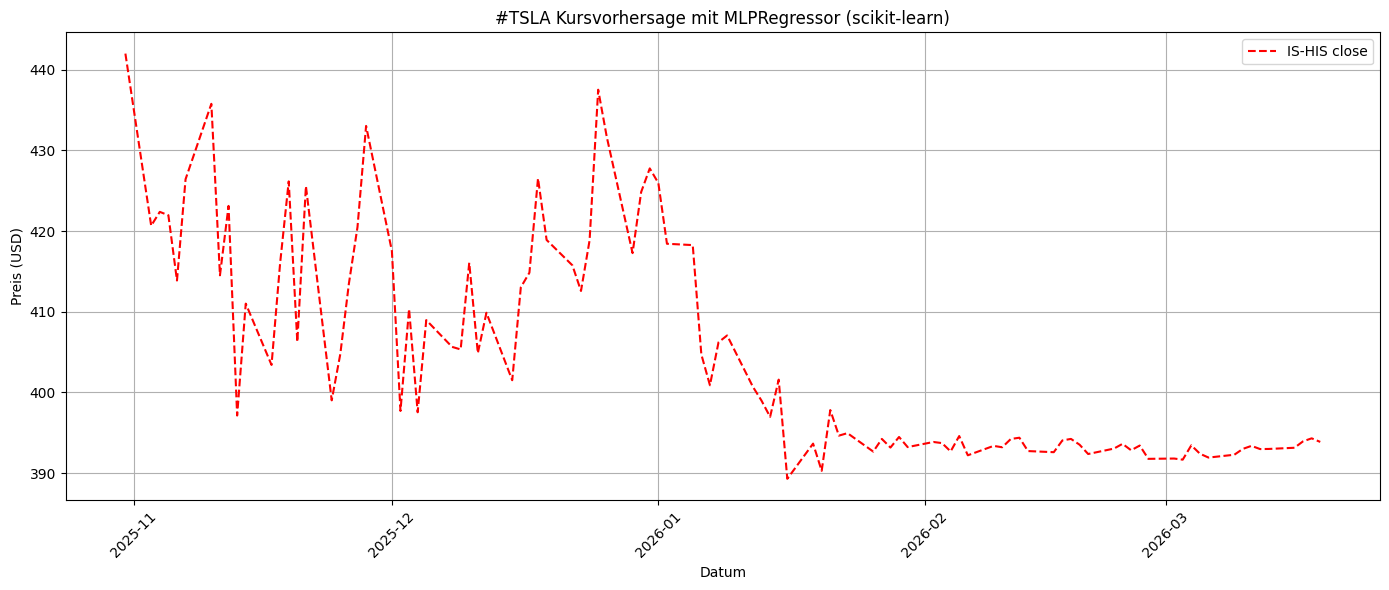

In [8]:
df1["date"] = pd.to_datetime(df1["date"]) 
#df1 = df1.set_index('date')

plt.figure(figsize=(14, 6))
#plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
plt.plot( df1['date'], df1['NN'], label='IS-HIS close', color='red',  linestyle='--' )

plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
#df1 = df1.set_index('date')
#df['NN'] = df1['NN'] 
print (df1)

         date          NN
0  2025-10-31  441.989713
1  2025-11-03  420.658246
2  2025-11-04  422.376812
3  2025-11-05  421.957039
4  2025-11-06  413.870181
..        ...         ...
95 2026-03-13  392.996276
96 2026-03-16  393.143997
97 2026-03-17  393.941059
98 2026-03-18  394.312147
99 2026-03-19  393.868086

[100 rows x 2 columns]


In [10]:
#df_fc =  pd.DataFrame ( df[['open', 'high', 'close','NN']] )
#print (df_fc)

df_combined = pd.concat([df, df1], ignore_index=True)


In [11]:
print (df_combined.tail(10) ) 

      Unnamed: 0 symbol  open  high  low  close  volume  adjclose ticker type  \
1090         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1091         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1092         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1093         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1094         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1095         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1096         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1097         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1098         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
1099         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   

      ...  MA_50  MA_200  RSI_14 Sentiment  MACD  Signal_Line  Returns  \
1090  ...    NaN     NaN     NaN  